In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from prophet import Prophet


In [6]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



In [7]:
def load_and_preprocess_data():
    print("Loading and preprocessing data...")
    df = pd.read_csv("/content/drive/MyDrive/data/data.csv")
    print(f" Data loaded from CSV successfully!")
    print(f" Column names: {list(df.columns)}")
    print(f" Original shape: {df.shape}")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    print(f" Missing values in Adj Close: {df['Adj Close'].isna().sum()}")
    df = df.dropna(subset=['Adj Close'])
    print(f" Final shape after cleaning: {df.shape}")
    print(f" Date range: {df.index.min()} to {df.index.max()}")
    return df



In [8]:
df = load_and_preprocess_data()

Loading and preprocessing data...
 Data loaded from CSV successfully!
 Column names: ['Date', 'Adj Close', 'Volume', 'IsDividend', 'DividendAmount', 'IsSplit', 'SplitRatio']
 Original shape: (4551, 7)
 Missing values in Adj Close: 0
 Final shape after cleaning: (4551, 6)
 Date range: 2007-01-25 00:00:00 to 2025-02-25 00:00:00


In [9]:
print("\n" + "="*50)
print(" DATA OVERVIEW")
print("="*50)
print(df.head())
print(f"\nData Info:")
print(f"- Total records: {len(df)}")
print(f"- Missing values in Adj Close: {df['Adj Close'].isna().sum()}")
print(f"- Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")



 DATA OVERVIEW
            Adj Close       Volume  IsDividend  DividendAmount  IsSplit  \
Date                                                                      
2007-01-25       2.60  905973600.0       False             0.0    False   
2007-01-26       2.57  986874000.0       False             0.0    False   
2007-01-29       2.59  901664400.0       False             0.0    False   
2007-01-30       2.57  577970400.0       False             0.0    False   
2007-01-31       2.58  856069200.0       False             0.0    False   

            SplitRatio  
Date                    
2007-01-25         0.0  
2007-01-26         0.0  
2007-01-29         0.0  
2007-01-30         0.0  
2007-01-31         0.0  

Data Info:
- Total records: 4551
- Missing values in Adj Close: 0
- Date range: 2007-01-25 to 2025-02-25


In [10]:
df

,Adj Close,Volume,IsDividend,DividendAmount,IsSplit,SplitRatio
Date,,,,,,
2007-01-25,2.60,905973600.0,False,0.0,False,0.0
2007-01-26,2.57,986874000.0,False,0.0,False,0.0
2007-01-29,2.59,901664400.0,False,0.0,False,0.0
2007-01-30,2.57,577970400.0,False,0.0,False,0.0
2007-01-31,2.58,856069200.0,False,0.0,False,0.0
...,...,...,...,...,...,...
2025-02-19,244.87,32204200.0,False,0.0,False,0.0
2025-02-20,245.83,32316900.0,False,0.0,False,0.0
2025-02-21,245.55,53197400.0,False,0.0,False,0.0



 TIME SERIES ANALYSIS
 Basic Statistics for Adj Close:
count    4551.000000
mean       58.547042
std        66.077750
min         2.350000
25%        11.220000
50%        25.880000
75%       107.235000
max       258.740000
Name: Adj Close, dtype: float64


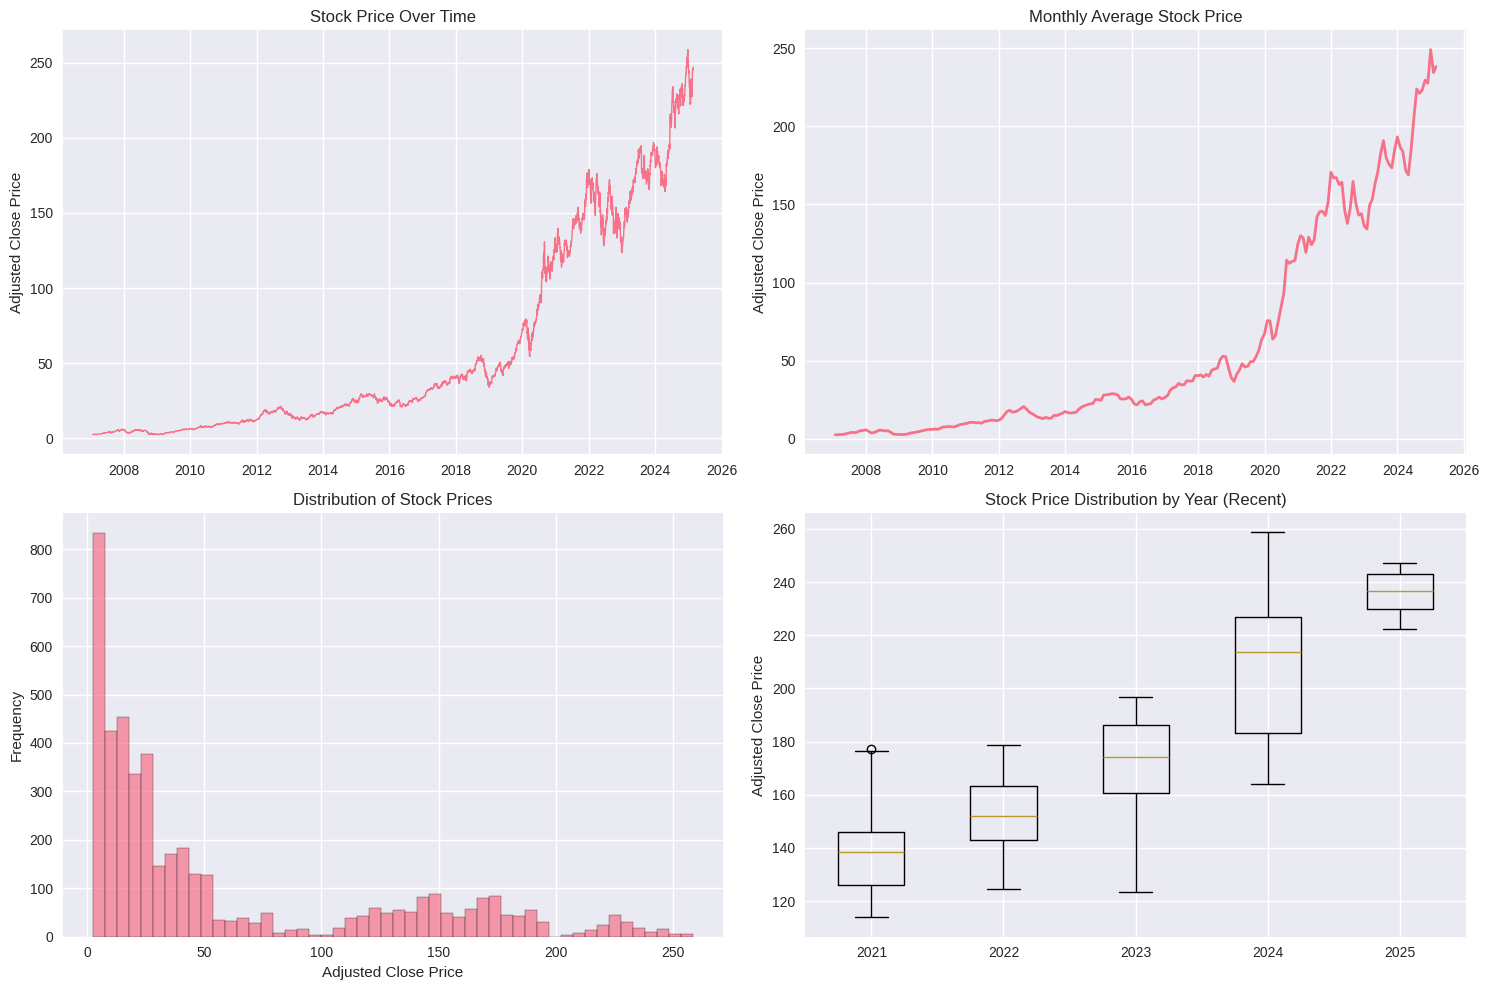

In [11]:
# ==================================================
# 2. TIME SERIES ANALYSIS AND VISUALIZATION
# ==================================================

def analyze_time_series(df):
    """
    Comprehensive time series analysis
    """
    print("\n" + "="*50)
    print(" TIME SERIES ANALYSIS")
    print("="*50)
    print(f" Basic Statistics for Adj Close:")
    print(df['Adj Close'].describe())
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes[0,0].plot(df.index, df['Adj Close'], linewidth=1)
    axes[0,0].set_title('Stock Price Over Time')
    axes[0,0].set_ylabel('Adjusted Close Price')
    axes[0,0].grid(True)
    monthly_data = df['Adj Close'].resample('M').mean()
    axes[0,1].plot(monthly_data.index, monthly_data.values, linewidth=2)
    axes[0,1].set_title('Monthly Average Stock Price')
    axes[0,1].set_ylabel('Adjusted Close Price')
    axes[0,1].grid(True)
    axes[1,0].hist(df['Adj Close'], bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribution of Stock Prices')
    axes[1,0].set_xlabel('Adjusted Close Price')
    axes[1,0].set_ylabel('Frequency')
    df_copy = df.copy()
    df_copy['Year'] = df_copy.index.year
    recent_years = df_copy[df_copy['Year'] >= 2020]
    if len(recent_years) > 0:
        years_to_plot = sorted(recent_years['Year'].unique())[-5:]  # Last 5 years
        box_data = [recent_years[recent_years['Year'] == year]['Adj Close'].values
                   for year in years_to_plot]
        axes[1,1].boxplot(box_data, labels=years_to_plot)
        axes[1,1].set_title('Stock Price Distribution by Year (Recent)')
        axes[1,1].set_ylabel('Adjusted Close Price')
    plt.tight_layout()
    plt.show()
    return monthly_data

monthly_data = analyze_time_series(df)


 STATIONARITY TESTS FOR MONTHLY STOCK PRICES
----------------------------------------
ADF Test Results:
  ADF Statistic: 1.982528
  p-value: 0.998650
  Critical Values:
    1%: -3.463
    5%: -2.876
    10%: -2.574
   Series is non-stationary (ADF test)

KPSS Test Results:
  KPSS Statistic: 1.865153
  p-value: 0.010000
   Series is non-stationary (KPSS test)

 TIME SERIES DECOMPOSITION
----------------------------------------


/tmp/ipython-input-13-136158101.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


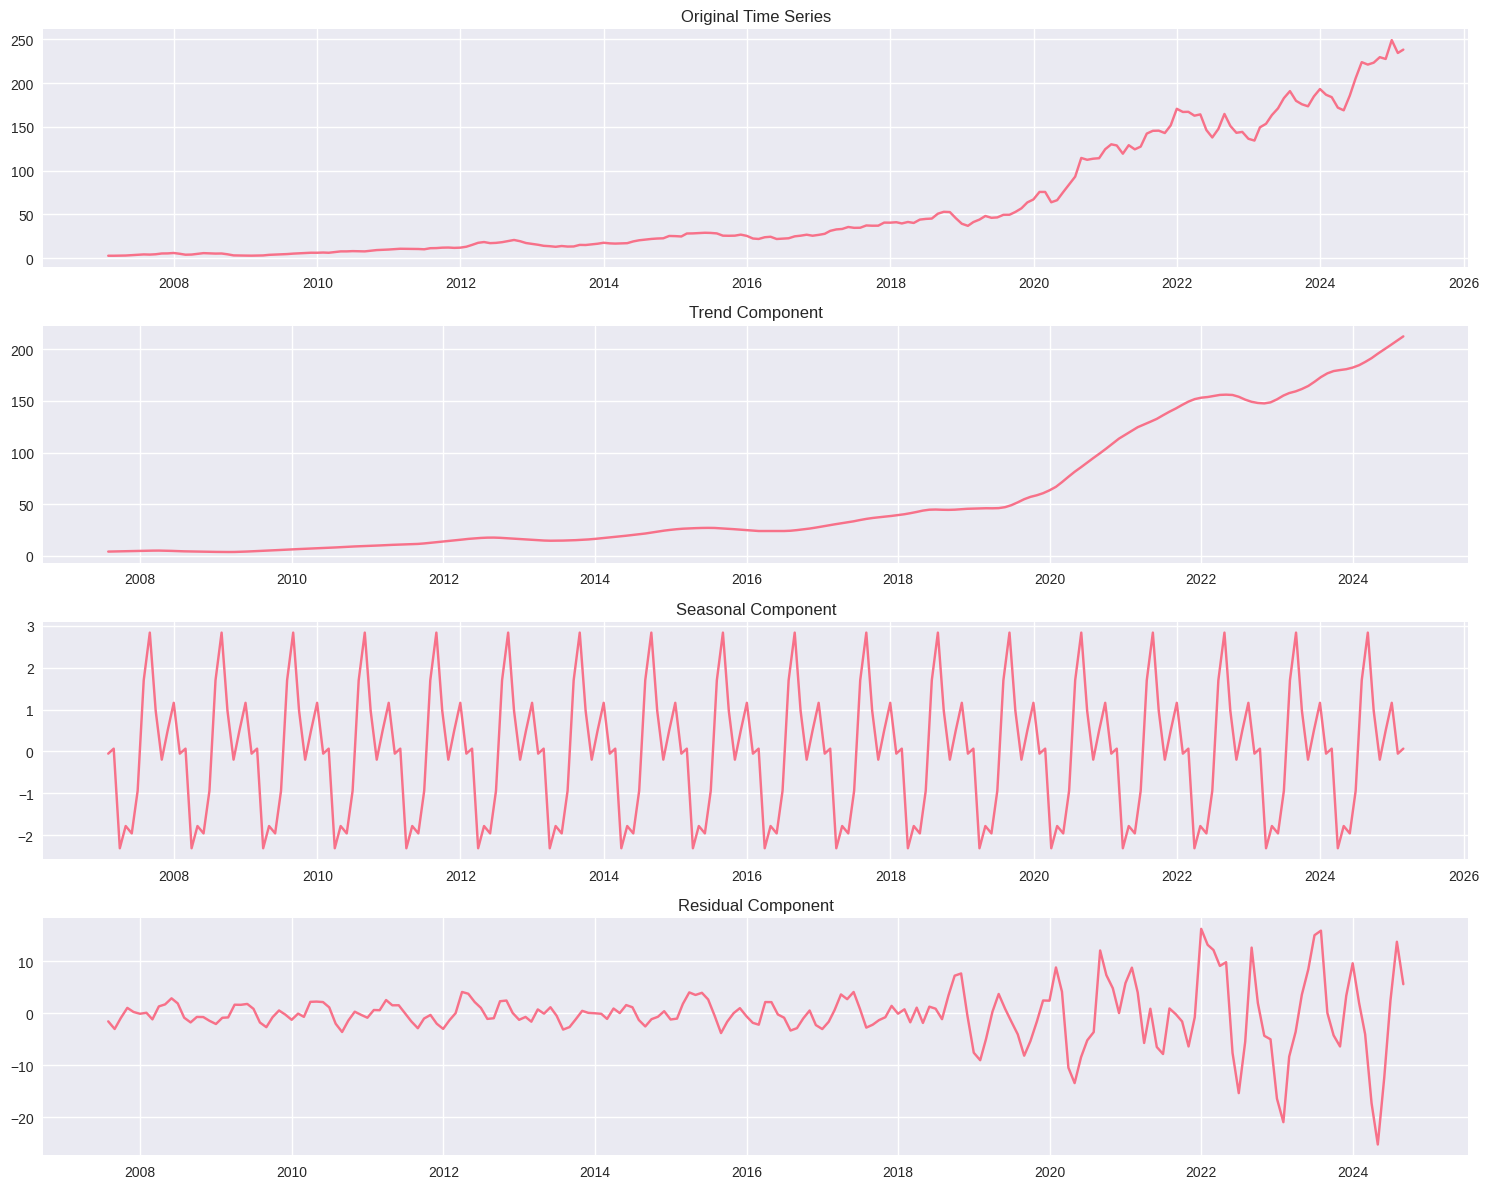

In [13]:
# ==================================================
# 3. STATIONARITY TESTS AND DECOMPOSITION
# ==================================================

def test_stationarity(timeseries, title="Time Series"):
    print(f"\n STATIONARITY TESTS FOR {title.upper()}")
    print("-" * 40)
    adf_result = adfuller(timeseries.dropna())
    print(f"ADF Test Results:")
    print(f"  ADF Statistic: {adf_result[0]:.6f}")
    print(f"  p-value: {adf_result[1]:.6f}")
    print(f"  Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.3f}")

    if adf_result[1] <= 0.05:
        print("   Series is stationary (ADF test)")
    else:
        print("   Series is non-stationary (ADF test)")
    try:
        kpss_result = kpss(timeseries.dropna())
        print(f"\nKPSS Test Results:")
        print(f"  KPSS Statistic: {kpss_result[0]:.6f}")
        print(f"  p-value: {kpss_result[1]:.6f}")

        if kpss_result[1] >= 0.05:
            print("   Series is stationary (KPSS test)")
        else:
            print("   Series is non-stationary (KPSS test)")
    except:
        print("   KPSS test failed")
test_stationarity(monthly_data, "Monthly Stock Prices")


def decompose_time_series(data, period=12):
    print(f"\n TIME SERIES DECOMPOSITION")
    print("-" * 40)

    decomposition = seasonal_decompose(data, model='additive', period=period)

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))


    axes[0].plot(decomposition.observed)
    axes[0].set_title('Original Time Series')
    axes[0].grid(True)

    axes[1].plot(decomposition.trend)
    axes[1].set_title('Trend Component')
    axes[1].grid(True)


    axes[2].plot(decomposition.seasonal)
    axes[2].set_title('Seasonal Component')
    axes[2].grid(True)


    axes[3].plot(decomposition.resid)
    axes[3].set_title('Residual Component')
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()

    return decomposition

decomposition = decompose_time_series(monthly_data)


 AUTOCORRELATION ANALYSIS
----------------------------------------


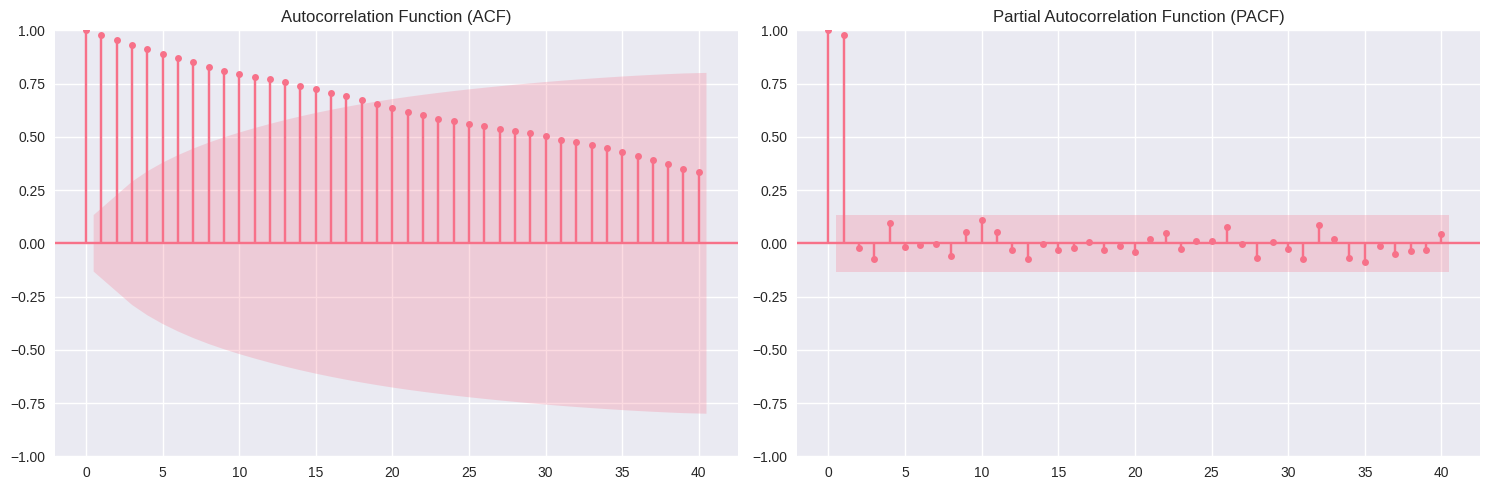

In [15]:
# ==================================================
# 4. ACF/PACF ANALYSIS
# ==================================================

def plot_acf_pacf(data, lags=40):
    print(f"\n AUTOCORRELATION ANALYSIS")
    print("-" * 40)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(data.dropna(), ax=axes[0], lags=lags)
    axes[0].set_title('Autocorrelation Function (ACF)')
    plot_pacf(data.dropna(), ax=axes[1], lags=lags)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()
plot_acf_pacf(monthly_data)

In [17]:
# ==================================================
# 5. PREPARE DATA FOR MODELING
# ==================================================

def prepare_data_for_modeling(data, test_size=12):
    print(f"\n PREPARING DATA FOR MODELING")
    print("-" * 40)

    # Split data
    train_size = len(data) - test_size
    train_data = data[:train_size]
    test_data = data[train_size:]

    print(f" Train size: {len(train_data)} months")
    print(f" Test size: {len(test_data)} months")
    print(f" Train period: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
    print(f" Test period: {test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')}")

    return train_data, test_data

train_data, test_data = prepare_data_for_modeling(monthly_data)



 PREPARING DATA FOR MODELING
----------------------------------------
 Train size: 206 months
 Test size: 12 months
 Train period: 2007-01 to 2024-02
 Test period: 2024-03 to 2025-02


In [18]:
# ==================================================
# 6. EXPONENTIAL SMOOTHING MODELS
# ==================================================

def fit_exponential_smoothing_models(train, test):
    print(f"\n EXPONENTIAL SMOOTHING MODELS")
    print("-" * 40)
    models = {}
    forecasts = {}
    try:
        model_ses = ExponentialSmoothing(train, trend=None, seasonal=None)
        fit_ses = model_ses.fit()
        forecast_ses = fit_ses.forecast(steps=len(test))
        models['Simple ES'] = fit_ses
        forecasts['Simple ES'] = forecast_ses
        print(" Simple Exponential Smoothing fitted")
    except Exception as e:
        print(f" Simple ES failed: {e}")

    try:
        model_holt = ExponentialSmoothing(train, trend='add', seasonal=None)
        fit_holt = model_holt.fit()
        forecast_holt = fit_holt.forecast(steps=len(test))
        models['Holt Linear'] = fit_holt
        forecasts['Holt Linear'] = forecast_holt
        print(" Holt's Linear Trend fitted")
    except Exception as e:
        print(f" Holt Linear failed: {e}")

    try:
        model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
        fit_hw = model_hw.fit()
        forecast_hw = fit_hw.forecast(steps=len(test))
        models['Holt-Winters'] = fit_hw
        forecasts['Holt-Winters'] = forecast_hw
        print(" Holt-Winters fitted")
    except Exception as e:
        print(f" Holt-Winters failed: {e}")

    return models, forecasts

es_models, es_forecasts = fit_exponential_smoothing_models(train_data, test_data)


 EXPONENTIAL SMOOTHING MODELS
----------------------------------------
 Simple Exponential Smoothing fitted
 Holt's Linear Trend fitted
 Holt-Winters fitted


In [19]:
# ==================================================
# 7. ARIMA FAMILY MODELS
# ==================================================

def fit_arima_models(train, test):
    print(f"\n ARIMA FAMILY MODELS")
    print("-" * 40)
    models = {}
    forecasts = {}
    try:
        model_arima = ARIMA(train, order=(1, 1, 1))
        fit_arima = model_arima.fit()
        forecast_arima = fit_arima.forecast(steps=len(test))
        models['ARIMA(1,1,1)'] = fit_arima
        forecasts['ARIMA(1,1,1)'] = forecast_arima
        print(" ARIMA(1,1,1) fitted")
        print(f"   AIC: {fit_arima.aic:.2f}")
    except Exception as e:
        print(f" ARIMA failed: {e}")

    try:
        model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        fit_sarima = model_sarima.fit(disp=False)
        forecast_sarima = fit_sarima.forecast(steps=len(test))
        models['SARIMA'] = fit_sarima
        forecasts['SARIMA'] = forecast_sarima
        print(" SARIMA fitted")
        print(f"   AIC: {fit_sarima.aic:.2f}")
    except Exception as e:
        print(f" SARIMA failed: {e}")

    return models, forecasts

arima_models, arima_forecasts = fit_arima_models(train_data, test_data)



 ARIMA FAMILY MODELS
----------------------------------------
 ARIMA(1,1,1) fitted
   AIC: 1208.71
 SARIMA fitted
   AIC: 1155.79


In [20]:
# ==================================================
# 8. MACHINE LEARNING MODELS
# ==================================================

def create_ml_features(data, window_size=12):
    df_ml = pd.DataFrame(index=data.index)


    for i in range(1, window_size + 1):
        df_ml[f'lag_{i}'] = data.shift(i)

    for window in [3, 6, 12]:
        df_ml[f'rolling_mean_{window}'] = data.rolling(window=window).mean()
        df_ml[f'rolling_std_{window}'] = data.rolling(window=window).std()


    df_ml['month'] = data.index.month
    df_ml['quarter'] = data.index.quarter
    df_ml['year'] = data.index.year


    df_ml['target'] = data

    return df_ml.dropna()

def fit_ml_models(train, test):

    print(f"\n MACHINE LEARNING MODELS")
    print("-" * 40)

    train_ml = create_ml_features(train)
    test_ml = create_ml_features(pd.concat([train, test]))

    test_ml = test_ml.loc[test.index]

    X_train = train_ml.drop('target', axis=1)
    y_train = train_ml['target']
    X_test = test_ml.drop('target', axis=1)

    models = {}
    forecasts = {}


    try:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_forecast = rf_model.predict(X_test)
        models['Random Forest'] = rf_model
        forecasts['Random Forest'] = pd.Series(rf_forecast, index=test.index)
        print(" Random Forest fitted")
    except Exception as e:
        print(f" Random Forest failed: {e}")

    try:
        xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_forecast = xgb_model.predict(X_test)
        models['XGBoost'] = xgb_model
        forecasts['XGBoost'] = pd.Series(xgb_forecast, index=test.index)
        print(" XGBoost fitted")
    except Exception as e:
        print(f" XGBoost failed: {e}")

    return models, forecasts, X_train.columns

ml_models, ml_forecasts, feature_names = fit_ml_models(train_data, test_data)



 MACHINE LEARNING MODELS
----------------------------------------
 Random Forest fitted
 XGBoost fitted


In [21]:
# ==================================================
# 9. DEEP LEARNING MODELS (Neural Networks)
# ==================================================

def fit_deep_learning_models(train, test):
    """
    Fit neural network models
    """
    print(f"\n DEEP LEARNING MODELS")
    print("-" * 40)
    train_ml = create_ml_features(train)
    test_ml = create_ml_features(pd.concat([train, test]))
    test_ml = test_ml.loc[test.index]

    X_train = train_ml.drop('target', axis=1)
    y_train = train_ml['target']
    X_test = test_ml.drop('target', axis=1)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    models = {}
    forecasts = {}
    try:
        mlp_model = MLPRegressor(
            hidden_layer_sizes=(100, 50),
            max_iter=1000,
            random_state=42,
            alpha=0.01
        )
        mlp_model.fit(X_train_scaled, y_train)
        mlp_forecast = mlp_model.predict(X_test_scaled)
        models['Neural Network'] = mlp_model
        forecasts['Neural Network'] = pd.Series(mlp_forecast, index=test.index)
        print(" Neural Network fitted")
    except Exception as e:
        print(f" Neural Network failed: {e}")

    return models, forecasts

dl_models, dl_forecasts = fit_deep_learning_models(train_data, test_data)



 DEEP LEARNING MODELS
----------------------------------------
 Neural Network fitted


In [22]:
# ==================================================
# 10. PROPHET MODEL
# ==================================================

def fit_prophet_model(train, test):
    """
    Fit Facebook Prophet model
    """
    print(f"\n PROPHET MODEL")
    print("-" * 40)

    try:
        prophet_train = pd.DataFrame({
            'ds': train.index,
            'y': train.values
        })
        prophet_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        prophet_model.fit(prophet_train)
        future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
        prophet_forecast = prophet_model.predict(future)
        forecast_values = prophet_forecast.tail(len(test))['yhat'].values
        forecast_series = pd.Series(forecast_values, index=test.index)

        print(" Prophet model fitted")
        return {'Prophet': prophet_model}, {'Prophet': forecast_series}

    except Exception as e:
        print(f" Prophet failed: {e}")
        return {}, {}

try:
    prophet_models, prophet_forecasts = fit_prophet_model(train_data, test_data)
except:
    prophet_models, prophet_forecasts = {}, {}
    print("Prophet not available - skipping")


 PROPHET MODEL
----------------------------------------


DEBUG:cmdstanpy:input tempfile: /tmp/tmptokvg5zu/ddlwu1qf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptokvg5zu/d4qkydi0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52841', 'data', 'file=/tmp/tmptokvg5zu/ddlwu1qf.json', 'init=/tmp/tmptokvg5zu/d4qkydi0.json', 'output', 'file=/tmp/tmptokvg5zu/prophet_modelinf000_5/prophet_model-20250621070640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:06:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:06:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Prophet model fitted


In [23]:
# ==================================================
# 11. EVALUATION METRICS
# ==================================================

def calculate_metrics(actual, forecast):
    """
    Calculate evaluation metrics
    """
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

def evaluate_all_models(test_data, *forecast_dicts):
    print(f"\n MODEL EVALUATION")
    print("=" * 50)

    all_forecasts = {}
    for forecast_dict in forecast_dicts:
        all_forecasts.update(forecast_dict)

    results = []

    for model_name, forecast in all_forecasts.items():
        if len(forecast) == len(test_data):
            metrics = calculate_metrics(test_data.values, forecast.values)
            metrics['Model'] = model_name
            results.append(metrics)

            print(f"\n{model_name}:")
            print(f"  RMSE: {metrics['RMSE']:.4f}")
            print(f"  MAE:  {metrics['MAE']:.4f}")
            print(f"  MAPE: {metrics['MAPE']:.4f}%")

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('RMSE')

        print(f"\n MODEL RANKING (by RMSE):")
        print("-" * 30)
        for i, (idx, row) in enumerate(results_df.iterrows(), 1):
            print(f"{i}. {row['Model']}: RMSE = {row['RMSE']:.4f}")

    return results_df
results = evaluate_all_models(
    test_data,
    es_forecasts,
    arima_forecasts,
    ml_forecasts,
    dl_forecasts,
    prophet_forecasts
)


 MODEL EVALUATION

Simple ES:
  RMSE: 39.9369
  MAE:  35.5484
  MAPE: 15.7842%

Holt Linear:
  RMSE: 29.1634
  MAE:  26.6692
  MAPE: 12.0054%

Holt-Winters:
  RMSE: 28.5091
  MAE:  25.9487
  MAPE: 11.6612%

ARIMA(1,1,1):
  RMSE: 39.8743
  MAE:  35.4953
  MAPE: 15.7623%

SARIMA:
  RMSE: 33.5748
  MAE:  30.5158
  MAPE: 13.6298%

Random Forest:
  RMSE: 38.9509
  MAE:  34.9422
  MAPE: 15.5208%

XGBoost:
  RMSE: 43.0708
  MAE:  39.0770
  MAPE: 17.4117%

Neural Network:
  RMSE: 8.3607
  MAE:  7.0768
  MAPE: 3.3158%

Prophet:
  RMSE: 18.0956
  MAE:  16.1943
  MAPE: 7.8313%

 MODEL RANKING (by RMSE):
------------------------------
1. Neural Network: RMSE = 8.3607
2. Prophet: RMSE = 18.0956
3. Holt-Winters: RMSE = 28.5091
4. Holt Linear: RMSE = 29.1634
5. SARIMA: RMSE = 33.5748
6. Random Forest: RMSE = 38.9509
7. ARIMA(1,1,1): RMSE = 39.8743
8. Simple ES: RMSE = 39.9369
9. XGBoost: RMSE = 43.0708



FORECAST VISUALIZATION
----------------------------------------


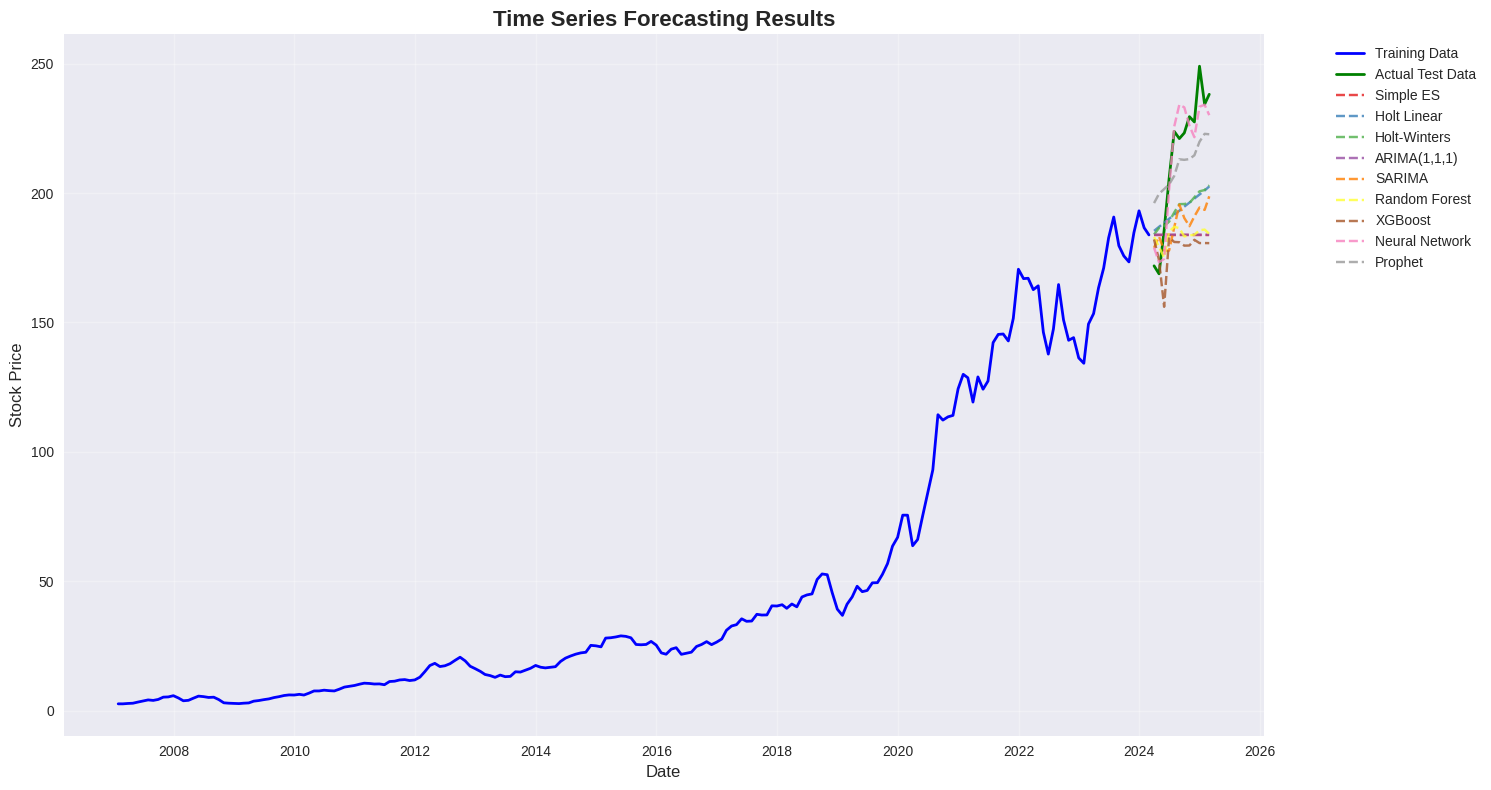

In [24]:
# ==================================================
# 12. VISUALIZATION OF RESULTS
# ==================================================

def plot_forecasts(train, test, *forecast_dicts):
    """
    Plot all forecasts
    """
    print(f"\nFORECAST VISUALIZATION")
    print("-" * 40)

    plt.figure(figsize=(15, 8))

    plt.plot(train.index, train.values, label='Training Data', color='blue', linewidth=2)
    plt.plot(test.index, test.values, label='Actual Test Data', color='green', linewidth=2)

    all_forecasts = {}
    for forecast_dict in forecast_dicts:
        all_forecasts.update(forecast_dict)
    colors = plt.cm.Set1(np.linspace(0, 1, len(all_forecasts)))

    for i, (model_name, forecast) in enumerate(all_forecasts.items()):
        if len(forecast) == len(test):
            plt.plot(test.index, forecast.values,
                    label=f'{model_name}',
                    color=colors[i],
                    linestyle='--',
                    alpha=0.8)

    plt.title('Time Series Forecasting Results', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_forecasts(
    train_data,
    test_data,
    es_forecasts,
    arima_forecasts,
    ml_forecasts,
    dl_forecasts,
    prophet_forecasts
)
